In [158]:
import numpy as np
import pandas as pd
import pyiso
import matplotlib.pyplot as plt

import time

import seaborn as sns

In [27]:
import time

# More Granular Electricity Demand Data via PyISO

After talking with Emily Fernandes, we realized that electricity demand needed to be on an even finer granularity in order for it to be useful at the ISO operations level. Since balancing happens in 1 minute increments, and 5 minute increments are the finest level data that is made publically available, we will be attempting to use the `pyiso` package to get these data.

**Docs for PyISO**: https://pyiso.readthedocs.io/en/latest/configuration.html

### Why pyiso? Why now?

After A TON of searching, it was virtually impossible to find an up-to-date specification on where to get 5min-level data from CAISO. While this data is clearly available (the `today's outlook` page on CAISO's website clearly updates every 5 minutes), it was virtually impossible to find. There are no available documentation available from CAISO itself without requiring a developer account, and documentation that's available online is at least 10 years old, and the links they provide don't work.

However, when we utilized links from the [FAQ provided by CAISO](http://www.caiso.com/Documents/OASIS-Frequently-Asked-Questions.pdf), we were able to get to 15 minute level data, but nothing deeper than that. In the 15 minute level data, however, they mention a data source (`XML_DATA_ITEM` column) called `SYS_FCST_15MIN_MW`. Naturally, that means there must be a `SYS_FCST_5MIN_NW` floating around somewhere in their server.

That's where pyiso comes in: it seems to have access to this 5 minute data, since it shows up in its [source code](https://pyiso.readthedocs.io/en/latest/_modules/pyiso/caiso.html).

In [ ]:
for date in ('20180101T00:00-0000' + timedelta(n) for n in range(day_count)):
    print ...

Our data goes back to sometime around mid-late 2014 (last checked date was 2014-01-01, and there was no data for that day.)

In [43]:
(np.datetime64('2016-01') + np.timedelta64(1, 'M')) < np.datetime64('2016-01-01')

False

In [44]:
start_time = np.datetime64('2015-01')
end_time = start_time + np.timedelta64(1, 'M')
data = []
while end_time <= np.datetime64('2016-01-01'):
    curr_start = start_time.astype(str) + "-01T00:00"
    curr_end = end_time.astype(str) + "-01T00:00"
    data.extend(pyiso.client_factory('CAISO').get_load(start_at=curr_start,end_at=curr_end))
    print("data up to ", curr_end, " loaded")
    start_time += np.timedelta64(1, 'M')
    end_time += np.timedelta64(1, 'M')
    time.sleep(0.25)

data up to  2015-02-01T00:00  loaded
data up to  2015-03-01T00:00  loaded
data up to  2015-04-01T00:00  loaded
data up to  2015-05-01T00:00  loaded
data up to  2015-06-01T00:00  loaded
data up to  2015-07-01T00:00  loaded
data up to  2015-08-01T00:00  loaded
data up to  2015-09-01T00:00  loaded
data up to  2015-10-01T00:00  loaded
data up to  2015-11-01T00:00  loaded
data up to  2015-12-01T00:00  loaded
data up to  2016-01-01T00:00  loaded


After retrieving the data, it's clear that we need to be careful with timezones: as imported, the data follows UTC time. If we're interested in doing meaningful analysis, we'll need to convert these times to PST.

In [171]:
df_2016 = pd.DataFrame(data)
df_2016 = df_2016.sort_values('timestamp')
df_2016

,timestamp,freq,market,ba_name,load_MW
171,2015-01-01 08:00:00+00:00,5m,RT5M,CAISO,23041.0
55,2015-01-01 08:05:00+00:00,5m,RT5M,CAISO,22937.0
77,2015-01-01 08:10:00+00:00,5m,RT5M,CAISO,22824.0
132,2015-01-01 08:15:00+00:00,5m,RT5M,CAISO,22707.0
111,2015-01-01 08:20:00+00:00,5m,RT5M,CAISO,22596.0
...,...,...,...,...,...
104485,2016-01-01 07:35:00+00:00,5m,RT5M,CAISO,22973.0
104612,2016-01-01 07:40:00+00:00,5m,RT5M,CAISO,22888.0
104486,2016-01-01 07:45:00+00:00,5m,RT5M,CAISO,22808.0
104487,2016-01-01 07:50:00+00:00,5m,RT5M,CAISO,22722.0


## Visualizing 2015 Electricity Demand Data

Seems like there might be some sort of outlier on April 3rd. Let's check around this date and see what's happening.

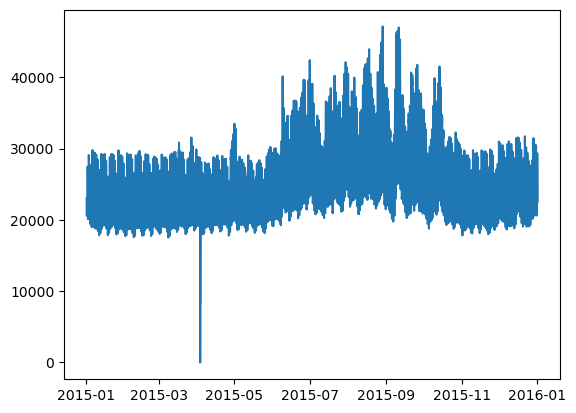

In [172]:
plt.plot(df_2016['timestamp'], df_2016['load_MW'])

In [173]:
df_2016[df_2016['load_MW'] < 10000]

,timestamp,freq,market,ba_name,load_MW
26361,2015-04-03 03:45:00+00:00,5m,RT5M,CAISO,8316.0
26258,2015-04-03 06:05:00+00:00,5m,RT5M,CAISO,0.0


(array([16527. , 16527.5, 16528. , 16528.5, 16529. , 16529.5, 16530. ]),
 [Text(16527.0, 0, '04-02 00'),
  Text(16527.5, 0, '04-02 12'),
  Text(16528.0, 0, '04-03 00'),
  Text(16528.5, 0, '04-03 12'),
  Text(16529.0, 0, '04-04 00'),
  Text(16529.5, 0, '04-04 12'),
  Text(16530.0, 0, '04-05 00')])

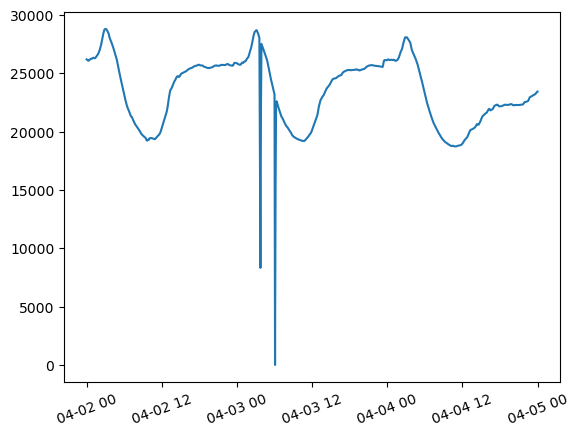

In [174]:
problem_range = df_2016[(df_2016['timestamp'] <= '2015-04-05') & (df_2016['timestamp'] >= '2015-04-02')].sort_values('timestamp', ascending=True)
plt.plot(problem_range['timestamp'], problem_range['load_MW'])
plt.xticks(rotation=20)

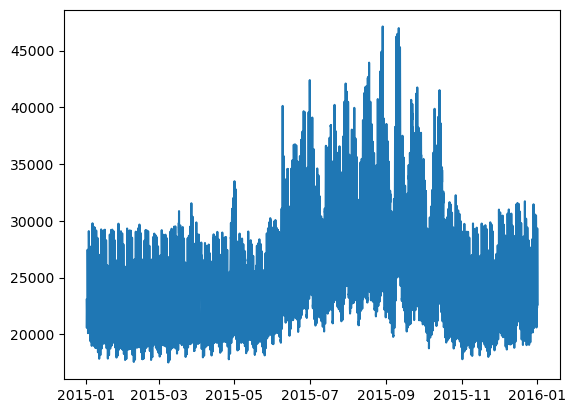

In [175]:
df_2016 = df_2016[(df_2016['timestamp'] < '2015-04-03') | (df_2016['timestamp'] >= '2015-04-04')]
plt.plot(df_2016['timestamp'], df_2016['load_MW'])

In [176]:
df_2016

,timestamp,freq,market,ba_name,load_MW
171,2015-01-01 08:00:00+00:00,5m,RT5M,CAISO,23041.0
55,2015-01-01 08:05:00+00:00,5m,RT5M,CAISO,22937.0
77,2015-01-01 08:10:00+00:00,5m,RT5M,CAISO,22824.0
132,2015-01-01 08:15:00+00:00,5m,RT5M,CAISO,22707.0
111,2015-01-01 08:20:00+00:00,5m,RT5M,CAISO,22596.0
...,...,...,...,...,...
104485,2016-01-01 07:35:00+00:00,5m,RT5M,CAISO,22973.0
104612,2016-01-01 07:40:00+00:00,5m,RT5M,CAISO,22888.0
104486,2016-01-01 07:45:00+00:00,5m,RT5M,CAISO,22808.0
104487,2016-01-01 07:50:00+00:00,5m,RT5M,CAISO,22722.0


## Identifying the Duck Curve

Now, let's identify the duck curve that Emily was talking about! To do this, we'll create a bit of a spaghetti plot and overlay every day's ducks on top of one another.

We'll start by converting our datetimes into PST, so that our visualization is more intuitive to understand!

In [177]:
df_2016['timestamp'] = df_2016['timestamp'].dt.tz_convert('US/Pacific')
df_2016

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/902780963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['timestamp'] = df_2016['timestamp'].dt.tz_convert('US/Pacific')


,timestamp,freq,market,ba_name,load_MW
171,2015-01-01 00:00:00-08:00,5m,RT5M,CAISO,23041.0
55,2015-01-01 00:05:00-08:00,5m,RT5M,CAISO,22937.0
77,2015-01-01 00:10:00-08:00,5m,RT5M,CAISO,22824.0
132,2015-01-01 00:15:00-08:00,5m,RT5M,CAISO,22707.0
111,2015-01-01 00:20:00-08:00,5m,RT5M,CAISO,22596.0
...,...,...,...,...,...
104485,2015-12-31 23:35:00-08:00,5m,RT5M,CAISO,22973.0
104612,2015-12-31 23:40:00-08:00,5m,RT5M,CAISO,22888.0
104486,2015-12-31 23:45:00-08:00,5m,RT5M,CAISO,22808.0
104487,2015-12-31 23:50:00-08:00,5m,RT5M,CAISO,22722.0


In [188]:
# Compute average duck
avg_compute = df_2016
avg_compute['time'] = avg_compute['viz'].dt.time
avg_compute = avg_compute.groupby('time')['load_MW'].mean()
avg_compute = avg_compute.reset_index()
avg_compute['time'] = avg_compute['time'].astype(str).astype('datetime64[ns]')
avg_compute

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/20042804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_compute['time'] = avg_compute['viz'].dt.time
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/20042804.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  avg_compute['time'] = avg_compute['time'].astype(str).astype('datetime64[ns]')


,time,load_MW
0,2023-10-16 00:00:00,22768.582173
1,2023-10-16 00:05:00,22632.938889
2,2023-10-16 00:10:00,22510.797784
3,2023-10-16 00:15:00,22401.826446
4,2023-10-16 00:20:00,22282.696970
...,...,...
283,2023-10-16 23:35:00,23515.027548
284,2023-10-16 23:40:00,23344.668508
285,2023-10-16 23:45:00,23189.267956
286,2023-10-16 23:50:00,23050.621170


/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/3840775375.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2016['viz'] = df_2016['timestamp'].dt.time.astype(str).astype('datetime64[ns]')
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/3840775375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['viz'] = df_2016['timestamp'].dt.time.astype(str).astype('datetime64[ns]')
/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_67072/3840775375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Text(0.5, 0, '')

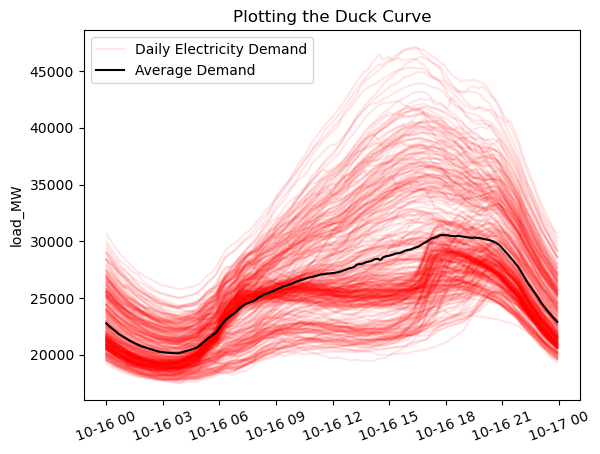

In [193]:
# Create new column of datetimes so axes between different plots are consistent (and so matplotlib can actually read these)
# Will return time-zone naive times, so for loop doesn't need to worry about them
df_2016['viz'] = df_2016['timestamp'].dt.time.astype(str).astype('datetime64[ns]') 
curr_day = np.datetime64("2015-01-01")
next_day = np.datetime64('2015-01-02')

# Overlays every day's duck curve on top of one another
labeled = 0
while next_day <= np.datetime64('2016-01-01'):
    if curr_day != '2015-04-03':
        curr_day_df = df_2016[(df_2016['timestamp'] < str(next_day)) & (df_2016['timestamp'] >= str(curr_day))]
        if not labeled:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1, label='Daily Electricity Demand')
            labeled += 1
        else:
            sns.lineplot(x='viz', y='load_MW', data=curr_day_df, c='r', alpha=0.1)
    curr_day += np.timedelta64(1, 'D')
    next_day += np.timedelta64(1, 'D')

# Compute average duck
avg_compute = df_2016
avg_compute['time'] = avg_compute['viz'].dt.time
avg_compute = avg_compute.groupby('time')['load_MW'].mean()
avg_compute = avg_compute.reset_index()
avg_compute['time'] = avg_compute['time'].astype(str).astype('datetime64[ns]')
sns.lineplot(x='time', y='load_MW', data=avg_compute, c='black', label='Average Demand')

plt.legend()
plt.xticks(rotation=20)
plt.title('Plotting the Duck Curve')
plt.xlabel('')

In [17]:
pd.DataFrame(data)

,timestamp,freq,market,ba_name,load_MW
0,2015-01-01 06:10:00+00:00,5m,RT5M,CAISO,25168.0
1,2015-01-01 00:25:00+00:00,5m,RT5M,CAISO,25095.0
2,2015-01-01 01:10:00+00:00,5m,RT5M,CAISO,27895.0
3,2015-01-01 01:45:00+00:00,5m,RT5M,CAISO,29141.0
4,2015-01-01 02:10:00+00:00,5m,RT5M,CAISO,29322.0
...,...,...,...,...,...
283,2015-01-01 15:10:00+00:00,5m,RT5M,CAISO,21976.0
284,2015-01-01 16:00:00+00:00,5m,RT5M,CAISO,22189.0
285,2015-01-01 16:50:00+00:00,5m,RT5M,CAISO,22203.0
286,2015-01-01 17:00:00+00:00,5m,RT5M,CAISO,22208.0
